In [1]:
'Ref: https://medium.com/swlh/modeling-insurance-claim-frequency-a776f3bf41dc
'

[1] "Ref: https://medium.com/swlh/modeling-insurance-claim-frequency-a776f3bf41dc\n"

In [ ]:
# Import Libraries

In [2]:
library("AER")
library("insuranceData")
library("repr")
library("statmod")
library(dplyr)
library(ggplot2)
library(statmod)
library("rsq")
data(dataCar)
library(countreg)
library(MASS)

Warning message:
"package 'AER' was built under R version 3.6.3"Loading required package: car
Warning message:
"package 'car' was built under R version 3.6.3"Loading required package: carData
Warning message:
"package 'carData' was built under R version 3.6.3"Loading required package: lmtest
Warning message:
"package 'lmtest' was built under R version 3.6.3"Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich
Warning message:
"package 'sandwich' was built under R version 3.6.3"Loading required package: survival
Warning message:
"package 'statmod' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following object is masked from 'package:car':

    recode

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwri

In [15]:
# Library Options

In [4]:
options(repr.plot.width=5, repr.plot.height=4)

In [ ]:
# Models

In [97]:
'Poisson:
    - Requires mean and variance to be equal.
    - If not, this is called over dispersion.
 Other Issues:
    - We should seek to model claim count as a function of exposure.
    - Use offset in GLM model.
      see ref: https://www.researchgate.net/post/What_is_the_role_of_an_offset_term_in_modelling_a_GLM

 Modeling Excessive Zero Counts
    - Zero Inflation:  Model the count and zero data separately.  Use Poisson or negative binomial for the
      count and logit for the zeros.
    - Hurdle Models

 Rootogram
    - https://www.itl.nist.gov/div898/software/dataplot/refman1/ch2/rootogra.pdf

 Why convert categorical variables to factors
    - https://stats.idre.ucla.edu/r/modules/factor-variables/
'

[1] "Poisson:\n    - Requires mean and variance to be equal.\n    - If not, this is called over dispersion.\n Other Issues:\n    - We should seek to model claim count as a function of exposure.\n    - Use offset in GLM model.\n      see ref: https://www.researchgate.net/post/What_is_the_role_of_an_offset_term_in_modelling_a_GLM\n\n Modeling Excessive Zero Counts\n    - Zero Inflation:  Model the count and zero data separately.  Use Poisson or negative binomial for the\n      count and logit for the zeros.\n    - Hurdle Models\n\n Rootogram\n    - https://www.itl.nist.gov/div898/software/dataplot/refman1/ch2/rootogra.pdf\n"

In [ ]:
###########################################################
# Insepect Data
###########################################################

In [30]:
# Create Training Dataset
'ref: https://cran.r-project.org/web/packages/dataPreparation/vignettes/train_test_prep.html'

[1] "ref: https://cran.r-project.org/web/packages/dataPreparation/vignettes/train_test_prep.html"

In [58]:
# Random Sample Indexes
train_index <- sample(1:nrow(dataCar), 0.7 * nrow(dataCar))    # sample (1 to number of rows, with sample size of 0.7)
test_index <- setdiff(1:nrow(dataCar), train_index)  # set function to remove 1:nrows from the train index

In [28]:
# Check if there is any overlap
overlap <- test_index %in% train_index

In [59]:
# Build X_train, X_test, y_train, y_test, Note: in R I don't believe you need the X and y split.
'
X_train <- dataCar[train_index, -grep("clm", colnames(dataCar))]    #use grep to get index location of target var and drop
y_train <- dataCar[train_index, "clm"]
X_test <- dataCar[test_index, -grep("clm", colnames(dataCar))]
y_test <- dataCar[test_index, "clm"]'


[1] "\nX_train <- dataCar[train_index, -grep(\"clm\", colnames(dataCar))]    #use grep to get index location of target var and drop\ny_train <- dataCar[train_index, \"clm\"]\nX_test <- dataCar[test_index, -grep(\"clm\", colnames(dataCar))]\ny_test <- dataCar[test_index, \"clm\"]"

ERROR: Error in `[.data.frame`(dataCar, train_index): undefined columns selected


In [62]:
train <- dataCar[train_index, ]
test <- dataCar[test_index, ]

In [5]:
summary(dataCar)

   veh_value         exposure             clm            numclaims      
 Min.   : 0.000   Min.   :0.002738   Min.   :0.00000   Min.   :0.00000  
 1st Qu.: 1.010   1st Qu.:0.219028   1st Qu.:0.00000   1st Qu.:0.00000  
 Median : 1.500   Median :0.446270   Median :0.00000   Median :0.00000  
 Mean   : 1.777   Mean   :0.468651   Mean   :0.06814   Mean   :0.07276  
 3rd Qu.: 2.150   3rd Qu.:0.709103   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :34.560   Max.   :0.999316   Max.   :1.00000   Max.   :4.00000  
                                                                        
   claimcst0          veh_body        veh_age      gender    area     
 Min.   :    0.0   SEDAN  :22233   Min.   :1.000   F:38603   A:16312  
 1st Qu.:    0.0   HBACK  :18915   1st Qu.:2.000   M:29253   B:13341  
 Median :    0.0   STNWG  :16261   Median :3.000             C:20540  
 Mean   :  137.3   UTE    : 4586   Mean   :2.674             D: 8173  
 3rd Qu.:    0.0   TRUCK  : 1750   3rd Qu.:4.000             

In [6]:
str(dataCar)

'data.frame':	67856 obs. of  11 variables:
 $ veh_value: num  1.06 1.03 3.26 4.14 0.72 2.01 1.6 1.47 0.52 0.38 ...
 $ exposure : num  0.304 0.649 0.569 0.318 0.649 ...
 $ clm      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ numclaims: int  0 0 0 0 0 0 0 0 0 0 ...
 $ claimcst0: num  0 0 0 0 0 0 0 0 0 0 ...
 $ veh_body : Factor w/ 13 levels "BUS","CONVT",..: 4 4 13 11 4 5 8 4 4 4 ...
 $ veh_age  : int  3 2 2 2 4 3 3 2 4 4 ...
 $ gender   : Factor w/ 2 levels "F","M": 1 1 1 1 1 2 2 2 1 1 ...
 $ area     : Factor w/ 6 levels "A","B","C","D",..: 3 1 5 4 3 3 1 2 1 2 ...
 $ agecat   : int  2 4 2 2 2 4 4 6 3 4 ...
 $ X_OBSTAT_: Factor w/ 1 level "01101    0    0    0": 1 1 1 1 1 1 1 1 1 1 ...


In [7]:
head(dataCar)

veh_value,exposure,clm,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,X_OBSTAT_
1.06,0.3039014,0,0,0,HBACK,3,F,C,2,01101 0 0 0
1.03,0.6488706,0,0,0,HBACK,2,F,A,4,01101 0 0 0
3.26,0.5694730,0,0,0,UTE,2,F,E,2,01101 0 0 0
4.14,0.3175907,0,0,0,STNWG,2,F,D,2,01101 0 0 0
0.72,0.6488706,0,0,0,HBACK,4,F,C,2,01101 0 0 0
2.01,0.8542094,0,0,0,HDTOP,3,M,C,4,01101 0 0 0


In [8]:
dataCar %>% group_by(clm) %>% summarise('Obs With Claims' = n())

clm,Obs With Claims
0,63232
1,4624


In [93]:
# Get Table - Num Observations By Claim Count
cntclaims <- dataCar %>% 
             group_by(numclaims) %>% 
             summarise('NumClaims' = n()) %>% 
             mutate(percent = round(NumClaims / sum(NumClaims), 3))
cntclaims

numclaims,NumClaims,percent
0,63232,0.932
1,4333,0.064
2,271,0.004
3,18,0.000
4,2,0.000


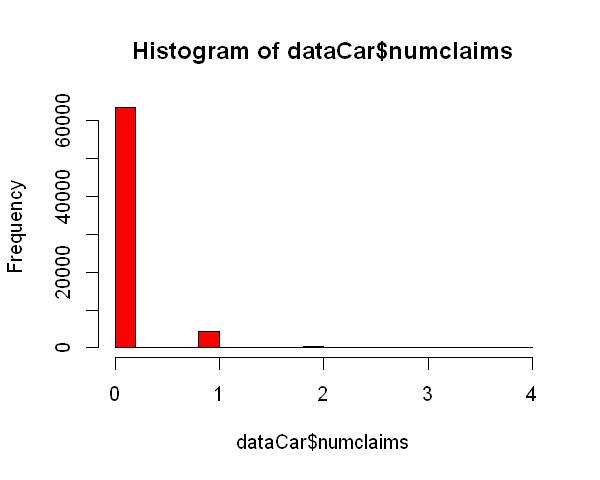

In [22]:
# Hist Num Claims
hist(dataCar$numclaims, col='red')

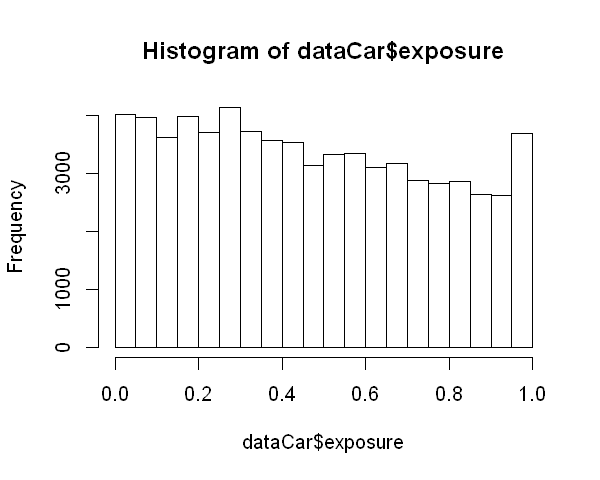

In [31]:
# Hist Exposure (so the duration of each policy)
hist(dataCar$exposure)

In [ ]:
# Fit Poisson Model
' Assessing model output
  https://stats.idre.ucla.edu/r/dae/poisson-regression/'

In [63]:
model.poisson <- glm(clm ~ veh_value + veh_body + gender + veh_age, data=train, family = "poisson", offset=log(exposure))

In [64]:
summary(model.poisson)


Call:
glm(formula = clm ~ veh_value + veh_body + gender + veh_age, 
    family = "poisson", data = train, offset = log(exposure))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8244  -0.4441  -0.3388  -0.2164   3.7064  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)   
(Intercept)   -0.91730    0.39057  -2.349  0.01884 * 
veh_value      0.01818    0.02163   0.840  0.40064   
veh_bodyCONVT -1.07084    0.70188  -1.526  0.12709   
veh_bodyCOUPE -0.44894    0.40326  -1.113  0.26559   
veh_bodyHBACK -0.89346    0.38029  -2.349  0.01880 * 
veh_bodyHDTOP -0.82911    0.39372  -2.106  0.03522 * 
veh_bodyMCARA -0.72983    0.53606  -1.361  0.17336   
veh_bodyMIBUS -1.04263    0.42441  -2.457  0.01402 * 
veh_bodyPANVN -0.76504    0.40635  -1.883  0.05974 . 
veh_bodyRDSTR -1.16473    1.07045  -1.088  0.27656   
veh_bodySEDAN -0.90900    0.37955  -2.395  0.01662 * 
veh_bodySTNWG -0.81266    0.38011  -2.138  0.03252 * 
veh_bodyTRUCK -0.92561    0.39392  -2.

In [69]:
# Predict Test Data
test.x <- subset(test, select = -clm)
pred.poisson <- predict(model.poisson, newdata = test.x, type='response')

In [ ]:
# Test for over dispersion
'Over vs under dispersion
 https://support.minitab.com/en-us/minitab/19/help-and-how-to/quality-and-process-improvement/control-charts/supporting-topics/understanding-attributes-control-charts/overdispersion-and-underdispersion/'

In [94]:
dispersiontest(model.poisson, trafo=1)


	Overdispersion test

data:  poissonglm
z = -35.512, p-value = 1
alternative hypothesis: true alpha is greater than 0
sample estimates:
      alpha 
-0.06814431 


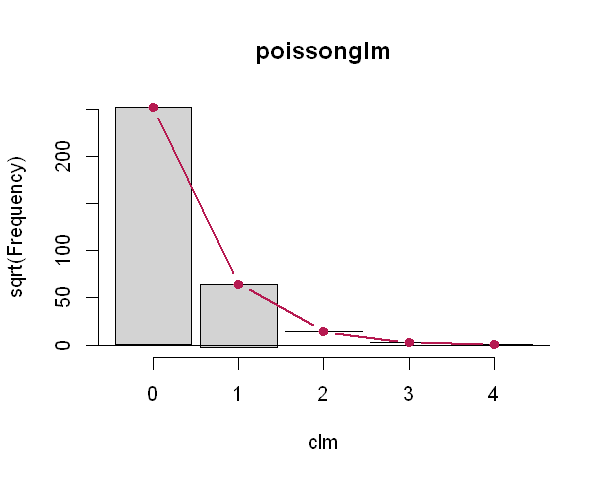

In [96]:
root.pios <- rootogram(model.poisson, style='hanging', plot=TRUE)
'Rootogram:
    expected counts, given the model, are shown by the thick red line,
    observed counts are shown as bars, which in a hanging rootogram are show hanging from the red line of expected counts,
    on the x-axis we have the count bin, 0 count, 1 count, 2 count, etc,
    on the y-axis we have the square root of the observed or expected count — the square root transformation allows for departures from expectations to be seen even at small frequencies
    A reference line is drawn at a height of 0
'

In [ ]:
# Fit Negative Binomial Model

In [13]:
model.nb <- glm.nb(clm ~ veh_value + veh_body + gender + veh_age, data=dataCar)

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"

In [14]:
model.nb$twologlik

[1] -34034.21

In [15]:
summary(model.nb)


Call:
glm.nb(formula = clm ~ veh_value + veh_body + gender + veh_age, 
    data = dataCar, init.theta = 1531.721242, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6893  -0.3737  -0.3653  -0.3566   2.3027  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.69821    0.34314  -4.949 7.46e-07 ***
veh_value      0.04768    0.01684   2.831 0.004644 ** 
veh_bodyCONVT -1.96884    0.67818  -2.903 0.003695 ** 
veh_bodyCOUPE -0.78814    0.35486  -2.221 0.026350 *  
veh_bodyHBACK -1.02530    0.33530  -3.058 0.002229 ** 
veh_bodyHDTOP -0.84368    0.34474  -2.447 0.014393 *  
veh_bodyMCARA -0.59453    0.42795  -1.389 0.164762    
veh_bodyMIBUS -1.13982    0.36674  -3.108 0.001884 ** 
veh_bodyPANVN -0.81079    0.35682  -2.272 0.023073 *  
veh_bodyRDSTR -1.10578    0.78286  -1.412 0.157807    
veh_bodySEDAN -1.04234    0.33468  -3.114 0.001843 ** 
veh_bodySTNWG -1.01363    0.33492  -3.026 0.002474 ** 
veh_bodyTRUCK -1.03142    

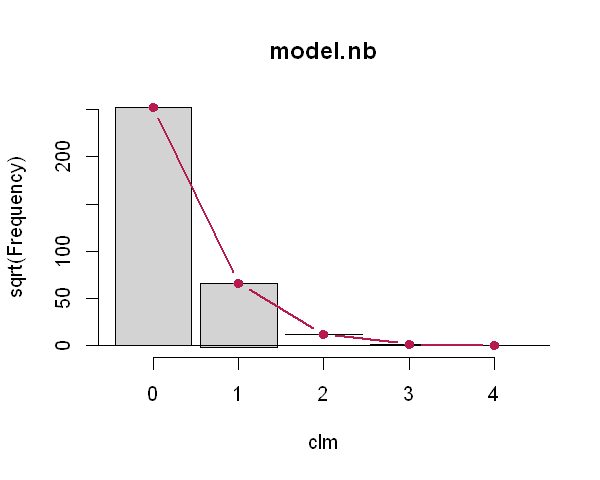

In [16]:
rootogram(model.nb, plot=TRUE)